In [1]:
! pip install --quiet --upgrade --user google-cloud-aiplatform

In [2]:
# A notebook's kernel restart may be required to ensure package installation.

import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [7]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user()

In [8]:
import os
import configparser
import random

import PIL.Image

from typing import Any
from pydantic import BaseModel, Field

import google.generativeai as genai
import vertexai
from vertexai.preview.vision_models import ImageGenerationModel, GeneratedImage
from vertexai.preview.vision_models import Image as vertexImage

In [9]:
# config = configparser.ConfigParser()
# config.read('../config.ini')
# api_key = config['credentials']['gemini_api_key']
# proj_id = config['credentials']['gcp_project_id']

In [10]:
# Enter details here
# info = {"PROJECT_ID": proj_id, "LOCATION" : "us-central1", "API_KEY" : api_key}

# Enter details here
info = {"PROJECT_ID": 'bannergenerator-436512', "LOCATION" : "us-central1", "API_KEY" : ""}

In [19]:
class BannerGenerator(BaseModel):
  """This class will be responsible for endpoints related to Image Generation mechanism"""

  CONFIGS: dict
  topic: str
  images: list | None = Field(default=None)
  text_model: str = "gemini-1.5-flash"
  image_model: str = "imagen-3.0-generate-001"
  edit_model: str = "imagegeneration@006"
  # image_model: str = "imagen-3.0-fast-generate-001"
  pm: Any = None
  im: Any = None
  em: Any = None
  text_v0: str = None
  text_v1: str = None
  text_v2: str = None
  text_v3: str = None
  text_v4: str = None
  img_response_v1: Any = None
  img_response_v2: Any = None
  img_response_v3: Any = None
  launch_state: bool = False

  def __launch(self):
    if self.launch_state is False:
      vertexai.init(project=self.CONFIGS['PROJECT_ID'], location=self.CONFIGS['LOCATION'])
      genai.configure(api_key = self.CONFIGS['API_KEY'])
      self.pm = genai.GenerativeModel(self.text_model)
      self.im = ImageGenerationModel.from_pretrained(self.image_model)
      self.em = ImageGenerationModel.from_pretrained(self.edit_model)
      self.launch_state = True
      print("Model Launch successful!")

  def extract_image_information(self):

    self.__launch()

    images = [PIL.Image.open(image_path) for image_path in self.images]
    model = self.pm
    extraction_prompt = '''Examine the set of images to provide concise unique insights about content, color, banner size and product (name, logo, tagline, size and packaging) in less than 150 words'''
    model_input = [extraction_prompt]
    model_input.extend(images)
    response = model.generate_content(model_input)
    print("Attached images examined!")
    return response.text

  def extract_information(self):

    self.__launch()

    # Information Gathering
    out_text = f"""Deep analyze text from retail advertising, marketing psychology and thoroughly researched marketing studies perspective: {self.topic}
    Fill the following information:
    0. Product: Product name, brand and supplier, logo, tagline, size, packaging
    1. Objective: 1 out of (Awareness, Engagement, Conversion, Branding)
    2. Age: Target audience age group. Examples - 'Below 18', '18-25', '25-40', '40-60', '60+'
    3. Gender: Preferred by which gender. Examples - MALE, FEMALE, NON BINARY, ALL
    4. Festival: Event or occasion it may be tied to. Examples - Christmas, Diwali, Black Friday, Summer Sale, New Year, Generic
    5. Headline: Attention capturing relevant main text. Examples - Innovate your life with it, Bring goodness to your life
    6. Subheadline: A promotional offer statement. Examples - Get 50% off until date, Exclusive deal for festive season, Hurry offer ends soon
    7. CTA: Compulsory add a call to action. Examples - Buy now, Shop the collection, Discover More, Sign up today
    8. Color Scheme: Use color palette based on audience, occasion, or product tone. Examples - Red & Gold (Festive, Urgency), Blue & White (Trust, Calm), Green & Brown (Eco-friendly, Natural), Black & White (Elegant, Minimal)
    9. Typography: Use font styles that resonate with the target demographic. Exampls - Sans-serif (Modern, Youthful), Serif (Traditional, Trustworthy), Script (Elegant, Formal), Display fonts (Playful, Bold)
    10. Visual Layout: Use layout pattern to guide user attention. Examples - F pattern (Text-heavy), Z pattern (Balanced visuals & text)
    11. Imagery: Use of product images and contextual photos. If provided reuse them else create own. Examples - Multiple product angles, Lifestyle imagery, Holiday-themed images, Close-up product features
    12. Branding: Ensure original logo and brand image. Top-left for logo, Consistent brand colors, Brand slogan or tagline inclusion
    13. Emotional Appeal: Emotion that the product evokes. Examples - Nostalgia (Older audiences, festive), Excitement (Younger audiences, sales), Trust and reliability (Product-focused), Aspiration (Luxury goods)
    14. Adaptability: Best device to display ad of product. If not provided use Website. Other examples - Mobile-first design, Large, clear CTA, Minimal text for mobile.
    15. Psychographics: Set levels for suitable OCEAN traits applicable. Examples - [High/Low Openness (Innovation, Creativity): Innovative, creative visuals], [High/Low Conscientiousness (Order, Reliability): Clean, organized layout], [High/Low Extraversion (Vibrancy, Sociability): Bold colors, active themes], [High/Low Agreeableness (Warmth, Trust): Soft tones, community appeal], [High/Low Neuroticism (Stability, Reassurance)]
    16. Region: Best location suited for product. Examples - USA, London, India, Generic
    17. Specifications: Aspect ratio: 1:7, Resolution: 1360px (width) x 800px (height) if other values not provided
    18. Ethnicity: Identify ethnicity of target population group that will purchase product most
    19. Promotional offer: Extract else suggest one best promotional offer. Examples - MAX ₹99 OFF, UP TO 60% OFF, UNDER ₹999, MIN ₹10 OFF, MIN 20% OFF, STARTS @₹99, FLAT ₹100 OFF, FLAT 20% OFF, ₹499 STORE, BUY 2 GET 1 FREE
    20. Background color gradient: Dynamic color generation to match overall look and feel
    21. Background theme: Festival oriented or generic if no festival

    Capture and modify any relevant extra information from your analysis in above respective buckets or extra buckets if needed.
    Only if key details are missing then use your pretrained data to come up with best suitable values for them.
    """
    self.text_v0 = self.pm.generate_content(out_text).text

    # Information consolidation
    out_text = f"Concisely summarize only in json format this text: {self.text_v0}"
    if self.images:
      image_info = self.extract_image_information()
      out_text += 'Product insights: ' + image_info
      print(f"Product insights:{image_info}")

    self.text_v1 = self.pm.generate_content(out_text).text[9:-5]

    # Scrapper
    out_text = f"Scrap all unavailable, unspecified and missing values from this json: {self.text_v1}"
    self.text_v2 = self.pm.generate_content(out_text).text

    print("Information collection complete!")

  def create_text_prompt(self):

    out_text = f"""Using guidelines modify values in this json: {self.text_v2}
    Guidelines:
    1. It will be used to generate an ads banner.
    2. Ensure it has all details pair wise meticulously captured.
    3. All unknown/missing/unprovided variables are replaced with the attributes of most probable shopper for that product.
    4. Recheck and identify all ambiguity or any text that leads to uncertainty.
    5. Replace all uncertainty with targeted values that make most sense for given product.
    6. Quantify everything possible like high, medium and lows to percentage values based on marketing and psychometric research studies.
    7. All KPIs and qualitative measures are used subcontextually only. Remove any details about statistical testing or names of any performance KPIs.
    8. Avoid sentences and use only necessary keywords.
    9. Remove all redundant key value pairs.
    """
    self.text_v3 = self.pm.generate_content(out_text).text

    print("Information processed!")

  def coherent_passage(self):
    out_text = f"Take a deep breath. Write a digital ad generating prompt for Imagen 3. It should be continous like a paragraph in a book, concise and under 400 words. Must have content for paragraph is here: {self.text_v1}"
    self.text_v4 = self.pm.generate_content(out_text).text
    print("Coherent passage generated.")

  def generate_image(self, passage:bool = False):
    if passage:
      self.coherent_passage()
      prompt = self.text_v4
    else:
      prompt = f"""Create a realistic professional looking digital ad banner using :{self.text_v3}"""

    self.img_response_v1 = self.im.generate_images(prompt=prompt)

    # Save v1
    temp_img_path = 'temp.jpg'
    os.remove(temp_img_path) if os.path.exists(temp_img_path) else None
    self.img_response_v1.images[0].save(temp_img_path)

    print("Image v1 generated!")

  def identify_lags(self):
    prompt = f"""Score this image on following points using benchmark:

    1. Visibility of brand name and logo
    2. Promotional offer visible distinctly and large
    3. No grammatical mistakes
    4. Product name
    5. Product picture
    6. Product size
    7. Product packaging
    8. Product tag line

    Use this as benchmark: {self.text_v3}

    Precisely identify errors.
    In case scoring is not possible then add relevant information to the best of your knowledge.
    Your response must NOT contain any aspect that have values similar to 'not applicable', 'missing', 'unspecified', 'not provided' etc.
    Your response must always be constructed like this structure only
    Visibility::+20%, Offer text size::+40%, Picture::-30%, Brightness::+50%, +Tagline::'Right for you', +Headline::'World's Best', +Text::'50% off' and so on.
    """
    model = self.pm
    model_input = [prompt, PIL.Image.open('temp.jpg')]
    response = model.generate_content(model_input)
    print(f'Lags identified::{response.text}')
    return response.text

  def fix_image(self, retest: bool = False):
    prompt = f'Fix image parameters: {self.identify_lags()}'

    model = self.em
    temp_img_path = 'temp.jpg'

    base_image = vertexImage.load_from_file(location=temp_img_path)

    self.img_response_v2 = model.edit_image(
      base_image=base_image,
      prompt=prompt,
      edit_mode="inpainting-insert",
      mask_mode="background"
      )

    print("Image v2 generated!")

    if retest:
      os.remove(temp_img_path) if os.path.exists(temp_img_path) else None
      self.img_response_v2.images[0].save(temp_img_path)

      prompt = f'Fix image parameters: {self.identify_lags()}'

      base_image = vertexImage.load_from_file(location=temp_img_path)

      self.img_response_v3 = model.edit_image(
      base_image=base_image,
      prompt=prompt,
      edit_mode="inpainting-insert",
      mask_mode="background"
      )

      print("Image v3 generated!")


  def display(self):
    print("="*100)
    print(f"Prompt v0: {self.text_v0}")

    print("="*100)
    print(f"Prompt v1: {self.text_v1}")

    print("="*100)
    print(f"Prompt v2: {self.text_v2}")

    print("="*100)
    print(f"Prompt v3: {self.text_v3}")

    try:
      print(f"Coherent passage: {self.text_v4}")
    except:
      pass

    print("="*100)
    self.img_response_v1.images[0].show()

    try:
      self.img_response_v2.images[0].show()
    except:
      pass

    try:
      self.img_response_v3.images[0].show()
    except:
      pass

  def execute(self, QC:bool=False, passage:bool=False):
    self.extract_information()
    self.create_text_prompt()
    self.generate_image(passage=passage)
    if QC:
      self.fix_image(retest=QC)
    self.display()

Model Launch successful!
Information collection complete!
Information processed!
Coherent passage generated.
Image v1 generated!
Prompt v0: ## Deep Analysis of "Good Day Biscuits at 20% Discount" Advertisement

**0. Product:**

* **Product name:** Good Day Biscuits
* **Brand:**  Good Day (Assuming it's a popular brand, details on supplier require additional research)
* **Logo:**  Use the official Good Day logo (If available)
* **Tagline:**  "Goodness in every bite" (Or use existing tagline if available)
* **Size:**  Specific size depends on the offer (e.g., Family Pack, Single Pack) - needs clarification
* **Packaging:**  Typical Good Day packaging - likely colorful, with the product image prominently displayed

**1. Objective:** Conversion (Drive sales with the discount)

**2. Age:** 25-60 (Good Day biscuits are a popular snack for families and working professionals)

**3. Gender:** ALL (Good Day biscuits appeal to both genders)

**4. Festival:** Generic (No specific event mentioned, 

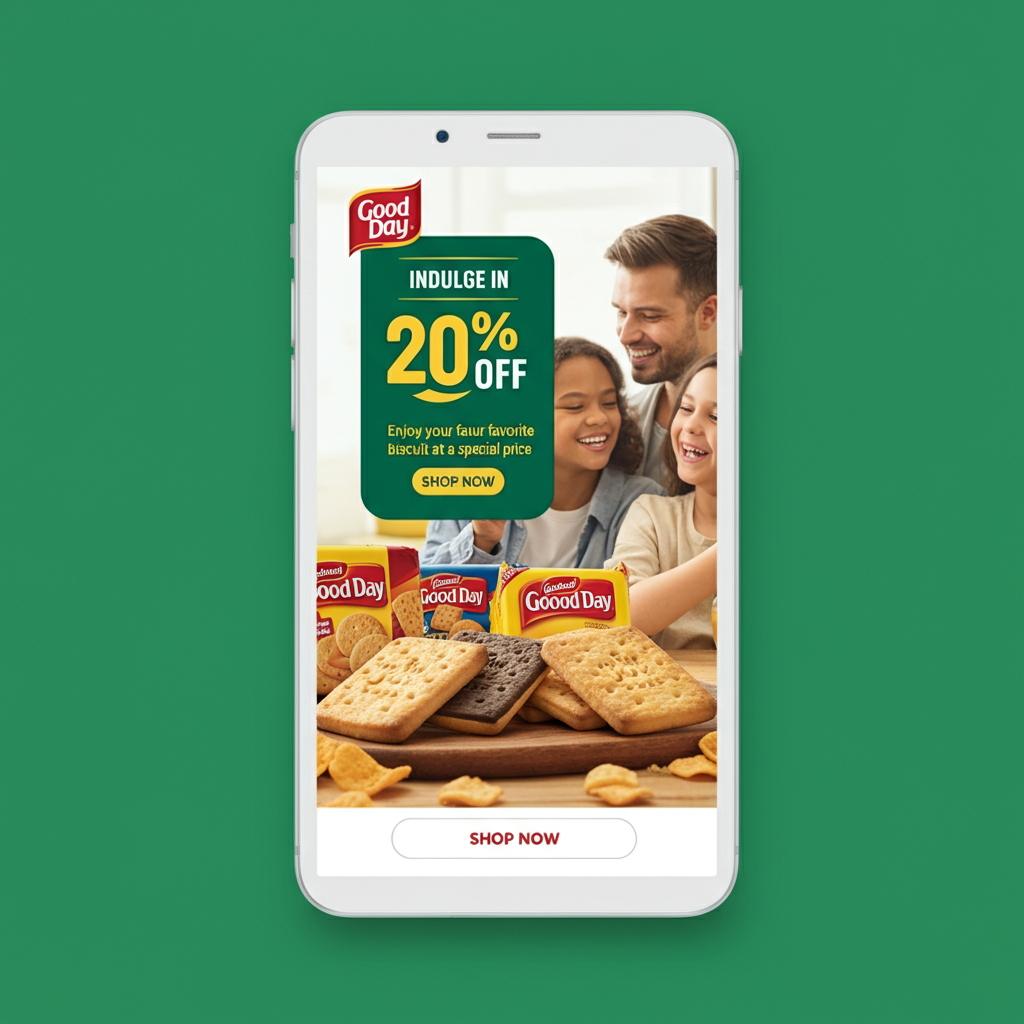

In [27]:
obj = BannerGenerator(CONFIGS = info, topic = "good day biscuits at 20% discount")
obj.execute(QC=False, passage=True)